# Scraping Data Dari Web jejakpiknik.com

In [2]:
# Import library yang akan digunakan untuk scraping
import requests  # Import library requests untuk mengambil data dari website
from bs4 import BeautifulSoup # Import BeautifulSoup dari bs4 untuk mem-parsing HTML
import pandas as pd  # Import pandas untuk mengolah data dalam bentuk tabel (DataFrame)
import re  # Import re (regular expression) untuk pencarian pola teks dalam HTML

In [6]:
# Daftar semua URL halaman wisata yang akan di-scrape
urls = [
    "https://jejakpiknik.com/tempat-wisata-di-bandung/",
    "https://jejakpiknik.com/wisata-alam-bandung/",
    "https://jejakpiknik.com/destinasi-wisata-bandung/",
    "https://jejakpiknik.com/tempat-rekreasi-di-bandung/",
    "https://jejakpiknik.com/tempat-liburan-di-bandung/",
    "https://jejakpiknik.com/tempat-wisata-di-lembang/",
    "https://jejakpiknik.com/wisata-lembang/",
    "https://jejakpiknik.com/wisata-ciwidey/"
]
# Definisikan fungsi untuk mengambil nama tempat dari setiap URL
# Fungsi ini mengambil teks dari tag <h3> yang mengandung angka di awal kalimat
def ambil_nama_tempat(url):
    res = requests.get(url)  # Mengirim permintaan HTTP ke URL
    soup = BeautifulSoup(res.text, "html.parser")  # Parsing HTML dari hasil permintaan
    konten = soup.find("div", class_="entry-content clear")  # Cari konten utama
    hasil = []  # List kosong untuk menyimpan hasil
    if konten:
        for tag in konten.find_all("h3"):  # Ambil semua tag <h3> dalam konten
            text = tag.get_text(strip=True)  # Ambil teks tanpa spasi awal/akhir
            if any(char.isdigit() for char in text[:4]):  # Cek apakah ada angka di awal (misal "1.")
                hasil.append(text)  # Simpan teks yang cocok
    return hasil  # Kembalikan list hasil

#  Loop ke semua URL dan kumpulkan hasil dari tiap halaman
semua_mentah = []  # Inisialisasi list kosong untuk semua hasil mentah
for url in urls:
    tempat = ambil_nama_tempat(url)  # Panggil fungsi scraping untuk tiap URL
    semua_mentah.extend(tempat)  # Tambahkan hasil ke list utama

# Cetak 60 hasil mentah yang telah dikumpulkan
print("Data mentah:")
for i in range(60):
    print("-", semua_mentah[i])

Data mentah:
- 1. Curug Tilu Leuwi Opat❤️
- 2. Curug Malela❤️
- 3. Gunung Artapela❤️
- 4. Gunung Nini❤️
- 5. Saung Angklung Mang Udjo❤️
- 6. Situ Cisanti❤️
- 7. Bukit Gantole Cililin❤️
- 8. Curug Cimahi❤️
- 9. Situ Cileunca❤️
- 10. Ciwangun Indah Camp❤️
- 11. Pemandian Air Panas Ciater❤️
- 12. Puncak Ciumbuleuit❤️
- 13. Bandung Treetop Adventure Park❤️
- 14. Terminal Wisata Grafika Cikole❤️
- 16. Situ Lembang❤️
- 17. Stone Garden Geo Park❤️
- 18. Bukit Moko❤️
- 19. NuArt Sculpture Park❤️
- 20. Pine Forest Camp❤️
- 21. Gua Pawon❤️
- 22. Taman Bunga Cihideung❤️
- 23. Babakan Siliwangi❤️
- 24. Bukit Teletubies❤️
- 25. Sanghyang Poek❤️
- 26. Kawah Rengganis❤️
- 27. Kampung Batu Malakasari❤️
- 28.GunungPuntang❤️
- 29. Bukit Bintang❤️
- 30. Desa Wisata Kampung Pasir Angling❤️
- 31. Curug Bellarosa❤️
- 32. Sendang Geulis Kahuripan❤️
- 33. Amazing Art World❤️
- 34. Upside Down World❤️
- 35. Curug Bugbrug❤️
- 36. Museum Geologi❤️
- 37. Kebun Binatang Bandung❤️
- 38. Kebun Teh Sukawana❤️
- 39. T

# Pembersihan Data Hasil Scraping

In [29]:
# Atur tampilan DataFrame agar tidak terpotong saat ditampilkan
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)

# Siapkan list penampung untuk tiap kategori data
judul_list = []   # Nama tempat wisata
alamat_list = []  # Alamat lokasi
harga_list = []   # Harga tiket masuk
telp_list = []    # Nomor telepon
jam_list = []     # Jam operasional

# Fungsi pembersih teks hasil ekstraksi
def clean_text(text):
    # Buang bagian promosi atau link internal yang sering muncul
    junk_keywords = [
        "halaman selanjutnya", "klik:", "lihat juga", "tempat wisata",
        "daftar selengkapnya", "lokasi objek", "selengkapnya"
    ]

    text_lower = text.lower()
    for keyword in junk_keywords:
        if keyword in text_lower:
            idx = text_lower.find(keyword)
            return text[:idx].strip()

    # Hanya menggunakan kalimat pertama
    if len(text) > 100:
        potong = text.split(".")[0]
        return potong.strip()

    return text.strip()

def extract_info(soup):
    alamat = harga = telp = jam = "Tidak tersedia"

    # Loop semua paragraf (karena <strong> ada di dalam <p>)
    for p in soup.find_all("p"):
        children = list(p.children)
        i = 0
        while i < len(children):
            el = children[i]

            # tag <strong>
            if el.name == "strong":
                label = el.get_text(strip=True).lower()

                # Gabungkan jika strong berikutnya hanya ":"
                if i + 1 < len(children) and getattr(children[i + 1], "name", None) == "strong":
                    label += children[i + 1].get_text(strip=True).lower()
                    i += 1

                # Ambil teks setelahnya
                next_text = ""
                if i + 1 < len(children):
                    sibling = children[i + 1]
                    if isinstance(sibling, str):
                        next_text = sibling.strip()
                    elif hasattr(sibling, "get_text"):
                        next_text = sibling.get_text(strip=True)

                # Skip jika iklan
                if next_text.lower() in ["klik disini", "klik di sini"]:
                    i += 1
                    continue

                label_lower = label.lower()

                # Pencocokan
                if any(k in label_lower for k in ["alamat", "lokasi", "letak", "map", "peta"]) and "koordinat" not in label_lower:
                    alamat = next_text or alamat

                elif any(k in label_lower for k in ["harga", "htm", "tarif", "tiket masuk", "biaya masuk"]):
                    harga = next_text or harga

                elif any(k in label_lower for k in ["telp", "telepon", "kontak", "no. telp", "no telepon"]):
                    match = re.search(r"(\+62|0)[\d\s\-()]{7,}", next_text)
                    telp = match.group() if match else next_text

                elif any(k in label_lower for k in ["jam", "operasional", "buka", "tutup", "waktu", "hari"]):
                    jam = next_text or jam

            i += 1

    return alamat.strip(), harga.strip(), telp.strip(), jam.strip()

# Loop ke semua URL dan ambil semua data tempat wisata
for url in urls:
    print(f"Scraping: {url}")
    res = requests.get(url)
    soup = BeautifulSoup(res.text, "html.parser")
    konten = soup.find("div", class_="entry-content clear")

    if konten:
        h3_tags = konten.find_all("h3")
        for h3 in h3_tags:
            text = h3.get_text(strip=True)
            if re.match(r"^\d+\.", text):
                nama = re.sub(r"^\d+\.\s*", "", text).replace("❤️", "").strip()

                # Ambil deskripsi sampai <h3> berikutnya
                next_tag = h3.find_next_sibling()
                desc_block = ""
                while next_tag and next_tag.name != "h3":
                    if next_tag.name in ["p", "li"]:
                        desc_block += str(next_tag)
                    next_tag = next_tag.find_next_sibling()

                # Ekstrak info dari blok deskripsi
                temp_soup = BeautifulSoup(desc_block, "html.parser")
                alamat, harga, telp, jam = extract_info(temp_soup)

                # Simpan hasil ke list
                judul_list.append(nama)
                alamat_list.append(alamat)
                harga_list.append(harga)
                telp_list.append(telp)
                jam_list.append(jam)

# Buat DataFrame hasil
df = pd.DataFrame({
    "Nama Tempat": judul_list,
    "Alamat": alamat_list,
    "Harga/Tiket": harga_list,
    "No. Telp": telp_list,
    "Jam Operasional": jam_list
})

# Tampilkan hasil
print(f"\nJumlah tempat ditemukan: {len(df)}\n")
print(df.to_string(index=True))


Scraping: https://jejakpiknik.com/tempat-wisata-di-bandung/
Scraping: https://jejakpiknik.com/wisata-alam-bandung/
Scraping: https://jejakpiknik.com/destinasi-wisata-bandung/
Scraping: https://jejakpiknik.com/tempat-rekreasi-di-bandung/
Scraping: https://jejakpiknik.com/tempat-liburan-di-bandung/
Scraping: https://jejakpiknik.com/tempat-wisata-di-lembang/
Scraping: https://jejakpiknik.com/wisata-lembang/
Scraping: https://jejakpiknik.com/wisata-ciwidey/

Jumlah tempat ditemukan: 60

                                   Nama Tempat                                                                                             Alamat                                                                                                                           Harga/Tiket                     No. Telp                                                                   Jam Operasional
0                        Curug Tilu Leuwi Opat                          Jl. Kp. Ciwangun Indah Camp, Desa Cihanjuang Raha

In [30]:
# Untuk mengetahu banyak data di tiap kategori
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Nama Tempat      60 non-null     object
 1   Alamat           60 non-null     object
 2   Harga/Tiket      60 non-null     object
 3   No. Telp         60 non-null     object
 4   Jam Operasional  60 non-null     object
dtypes: object(5)
memory usage: 2.5+ KB
None


In [32]:
# Buang baris-baris yang memiliki data penting kosong atau "Tidak tersedia"
# Kolom yang dicek: Harga/Tiket, No. Telp, Alamat, dan Jam Operasional
df_bersih = df[
    (df["Harga/Tiket"] != "Tidak tersedia") &
    (df["No. Telp"] != "Tidak tersedia") &
    (df["Alamat"] != "Tidak tersedia") &
    (df["Jam Operasional"] != "Tidak tersedia")
]

# Reset index agar urutannya kembali dari 0 setelah baris dibuang
df_bersih = df_bersih.reset_index(drop=True)
# Tampilkan DataFrame hasil pembersihan
print(df_bersih.to_string(index=True))

                                   Nama Tempat                                                                                             Alamat                                                                                                                           Harga/Tiket                    No. Telp                                                                   Jam Operasional
0                        Curug Tilu Leuwi Opat                          Jl. Kp. Ciwangun Indah Camp, Desa Cihanjuang Rahayu, Kecamatan Parongpong                                                                                                                             Rp.10.000              0812-2224-6821                                                                 06.00 – 18.00 WIB
1                              Gunung Artapela                                                                 Desa Sukapura, Kecamatan Kertasari                                                                           

# Pengolahan Data
## Pengelompokkan Tarif

In [33]:
# Definisikan fungsi untuk mengategorikan tarif berdasarkan isi kolom Harga/Tiket
def kategorikan_tarif(harga):
    # Cek jika datanya kosong atau NaN
    if pd.isna(harga):
        return "Tidak diketahui"

    # Ubah ke huruf kecil untuk memudahkan pencarian kata "gratis"
    harga = str(harga).lower()
    if "gratis" in harga:
        return "Gratis"

    # Ambil semua angka dari string (mengabaikan titik pemisah ribuan)
    angka_list = re.findall(r"\d+", harga.replace(".", ""))
    angka_list = [int(a) for a in angka_list if a.isdigit()]

    # Jika ditemukan angka, ambil harga minimum dan kategorikan
    if angka_list:
        min_harga = min(angka_list)
        if min_harga <= 15000:
            return "Murah"
        elif min_harga <= 30000:
            return "Menengah"
        else:
            return "Mahal"
    else:
        return "Tidak diketahui"

# Terapkan fungsi ke setiap baris kolom Harga/Tiket
df_bersih["Kategori Tarif"] = df_bersih["Harga/Tiket"].apply(kategorikan_tarif)

# Tampilkan jumlah tempat wisata per kategori tarif
print("Jumlah Wisata per Kategori Tarif:")
print(df_bersih["Kategori Tarif"].value_counts())


Jumlah Wisata per Kategori Tarif:
Kategori Tarif
Murah       22
Mahal        8
Gratis       4
Menengah     2
Name: count, dtype: int64


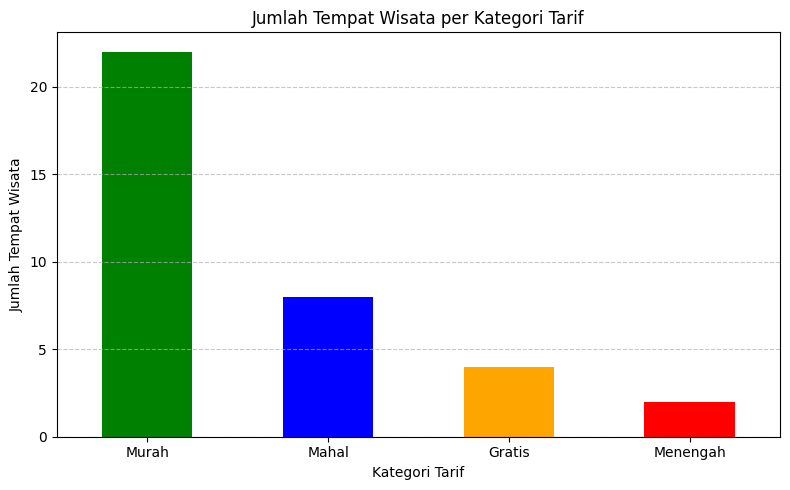

In [34]:
# Import library matplotlib untuk visualisasi data
import matplotlib.pyplot as plt

# Hitung jumlah tempat wisata per kategori tarif
tarif_counts = df_bersih["Kategori Tarif"].value_counts()

# Buat diagram batang dari hasil value_counts
plt.figure(figsize=(8, 5))  # Atur ukuran gambar
tarif_counts.plot(kind="bar", color=["green", "blue", "orange", "red"])  # Jenis diagram & warna batang

# Judul dan label sumbu
plt.title("Jumlah Tempat Wisata per Kategori Tarif")
plt.xlabel("Kategori Tarif")
plt.ylabel("Jumlah Tempat Wisata")

# Atur tampilan sumbu X dan garis bantu di sumbu Y
plt.xticks(rotation=0)  # Teks horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tampilkan plot
plt.tight_layout()
plt.show()


# Pengolahan Data
## Pengelompokkan Wilayah

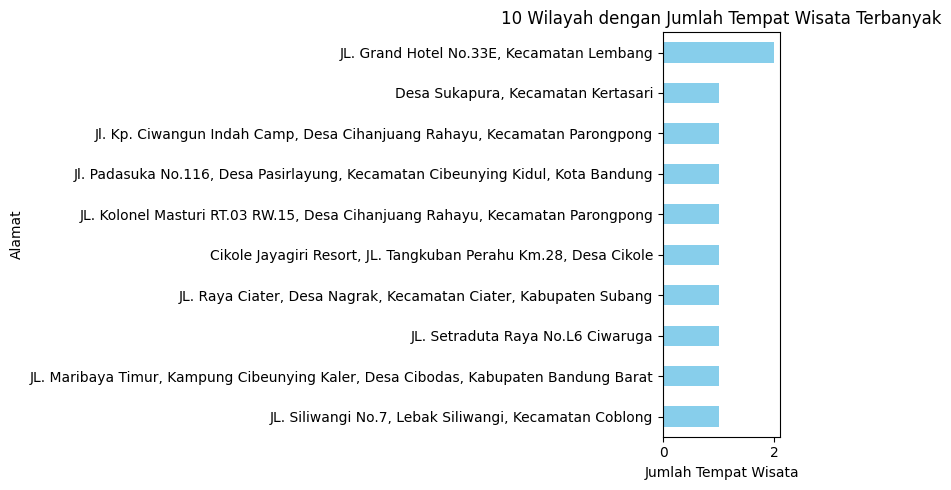

In [35]:
# Import pustaka visualisasi
import matplotlib.pyplot as plt

# Menghitung 10 wilayah teratas berdasarkan jumlah tempat wisata (dari kolom 'Alamat')
wilayah_counts = df_bersih["Alamat"].value_counts().head(10)

# Membuat diagram batang horizontal
plt.figure(figsize=(8, 5))  # Mengatur ukuran gambar
wilayah_counts.plot(kind="barh", color="skyblue")  # Menampilkan grafik batang horizontal

# Menambahkan judul dan label sumbu
plt.title("10 Wilayah dengan Jumlah Tempat Wisata Terbanyak")
plt.xlabel("Jumlah Tempat Wisata")

# Membalik urutan sumbu Y agar peringkat tertinggi berada di atas
plt.gca().invert_yaxis()

# Mengatur tata letak agar elemen tidak terpotong
plt.tight_layout()

# Menampilkan visualisasi
plt.show()


In [36]:
# Fungsi untuk mengekstrak nama wilayah (kecamatan, desa, kota, atau kabupaten) dari kolom 'Alamat'
def ekstrak_wilayah(alamat):
    if pd.isna(alamat):
        return "Lainnya"  # Jika data kosong, kembalikan "Lainnya"

    alamat = alamat.strip()  # Hilangkan spasi di awal/akhir

    # Deteksi pola umum yang sering muncul di alamat
    kec = re.search(r"Kecamatan ([\w\s]+)", alamat, re.I)
    if kec:
        return kec.group(1).strip()

    desa = re.search(r"Desa ([\w\s]+)", alamat, re.I)
    if desa:
        return desa.group(1).strip()

    kota = re.search(r"Kota ([\w\s]+)", alamat, re.I)
    if kota:
        return kota.group(1).strip()

    kab = re.search(r"Kabupaten ([\w\s]+)", alamat, re.I)
    if kab:
        return kab.group(1).strip()

    # Jika tidak ditemukan pola umum, ambil kata terakhir yang berupa huruf (bukan angka/simbol)
    kata = re.findall(r"[a-zA-Z]+", alamat)
    if kata:
        return kata[-1].strip().title()

    return "Lainnya"  # Jika tidak ditemukan apapun

# Menerapkan fungsi ke kolom 'Alamat' dan membuat kolom baru bernama 'Wilayah'
df_bersih["Wilayah"] = df_bersih["Alamat"].apply(ekstrak_wilayah)

# Menampilkan jumlah tempat wisata per wilayah
print(df_bersih["Wilayah"].value_counts())


Wilayah
Lembang             13
Coblong              3
Rancabali            2
Parongpong           2
Cibodas              2
Cikole               2
Kertasari            1
Ciater               1
Ciwaruga             1
Cibeunying Kidul     1
Banjaran             1
Baleendah            1
Cikalong Wetan       1
Sukasari             1
Cimenyan             1
Cibeunying Kaler     1
Batununggal          1
Ciwidey              1
Name: count, dtype: int64


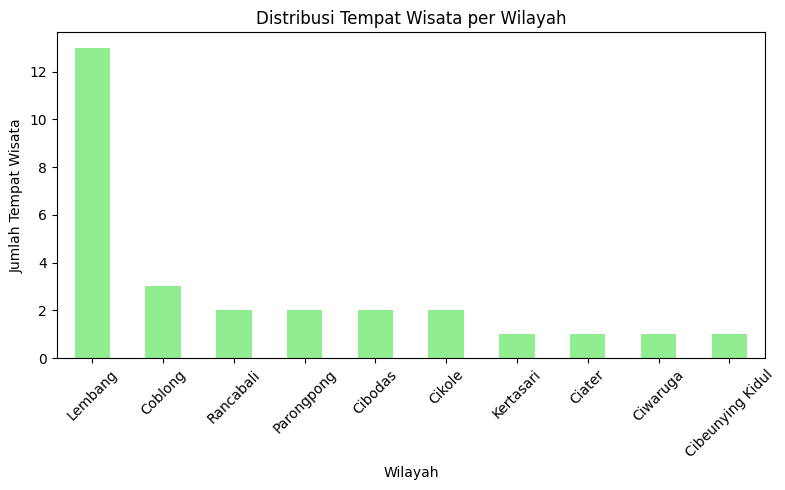

In [37]:
# Import pustaka visualisasi
import matplotlib.pyplot as plt

# Menghitung 10 wilayah dengan jumlah tempat wisata terbanyak
wilayah_counts = df_bersih["Wilayah"].value_counts().head(10)

# Membuat diagram batang vertikal
plt.figure(figsize=(8, 5))  # Menentukan ukuran gambar
wilayah_counts.plot(kind="bar", color="lightgreen")  # Menampilkan diagram batang dengan warna hijau muda

# Menambahkan judul dan label sumbu
plt.title("Distribusi Tempat Wisata per Wilayah")
plt.ylabel("Jumlah Tempat Wisata")
plt.xlabel("Wilayah")

# Mengatur rotasi label pada sumbu X untuk meningkatkan keterbacaan
plt.xticks(rotation=45)

# Merapikan tata letak agar elemen tidak terpotong
plt.tight_layout()

# Menampilkan grafik
plt.show()


# Pengolahan Data
## Pengelompokkan Jam Operasional

In [42]:
# Fungsi untuk menguraikan format jam operasional campuran menjadi jadwal harian per hari
# List nama hari
hari_list = ["Senin", "Selasa", "Rabu", "Kamis", "Jumat", "Sabtu", "Minggu"]

# Fungsi parsing jam operasional campuran
def parse_operasional_campuran(op):
    hari_alias = {"Jum'at": "Jumat", "Jum’at": "Jumat", "JUMAT": "Jumat"}
    hari_lengkap = hari_list
    jadwal = {h: "-" for h in hari_lengkap}

    if not isinstance(op, str):
        return jadwal

    op = op.replace("–", "-").replace("—", "-")
    op = op.replace("’", "'").replace("‘", "'")
    op = re.sub(r"dan Hari Libur", "", op, flags=re.I)

    # Jika "24 Jam" atau "Tutup" atau langsung jam
    if re.fullmatch(r"(24\s*Jam|Tutup|[\d.]+\s*-\s*[\d.]+.*)", op.strip()):
        return {h: op.strip() for h in hari_lengkap}

    bagian = [b.strip() for b in re.split(r",\s*", op)]

    for b in bagian:
        m = re.match(r"(.+?)\s+(\d{2}\.\d{2}\s*-\s*\d{2}\.\d{2})", b)
        if not m:
            continue
        rentang_hari, jam = m.groups()

        rentang_hari = rentang_hari.replace("–", "-")
        rentang_hari = " ".join([hari_alias.get(word, word) for word in rentang_hari.split()])

        if "-" in rentang_hari:
            awal, akhir = [x.strip().capitalize() for x in rentang_hari.split("-")]
            try:
                idx1 = hari_lengkap.index(awal)
                idx2 = hari_lengkap.index(akhir)
                for h in hari_lengkap[idx1:idx2+1]:
                    jadwal[h] = jam
            except:
                continue
        else:
            for h in hari_lengkap:
                if h in rentang_hari:
                    jadwal[h] = jam

    return jadwal

# Ganti nama kolom "Wilayah" menjadi "Tempat" agar lebih sesuai konteks
df_bersih = df_bersih.rename(columns={"Wilayah": "Tempat"})

# Terapkan fungsi parsing jam operasional dan ubah hasil dict menjadi kolom per hari
df_jadwal = df_bersih["Jam Operasional"].apply(parse_operasional_campuran).apply(pd.Series)

# Gabungkan dengan nama tempat agar informasi tetap terhubung
df_final = pd.concat([df_bersih[["Tempat"]], df_jadwal], axis=1)

# Tampilkan hasil akhir
print(df_final.to_string(index=True))


              Tempat              Senin             Selasa               Rabu              Kamis              Jumat              Sabtu             Minggu
0         Parongpong  06.00 - 18.00 WIB  06.00 - 18.00 WIB  06.00 - 18.00 WIB  06.00 - 18.00 WIB  06.00 - 18.00 WIB  06.00 - 18.00 WIB  06.00 - 18.00 WIB
1          Kertasari  08.00 - 17.00 WIB  08.00 - 17.00 WIB  08.00 - 17.00 WIB  08.00 - 17.00 WIB  08.00 - 17.00 WIB  08.00 - 17.00 WIB  08.00 - 17.00 WIB
2   Cibeunying Kidul  09.00 - 15.30 WIB  09.00 - 15.30 WIB  09.00 - 15.30 WIB  09.00 - 15.30 WIB  09.00 - 15.30 WIB  09.00 - 15.30 WIB  09.00 - 15.30 WIB
3         Parongpong  07.00 - 19.30 WIB  07.00 - 19.30 WIB  07.00 - 19.30 WIB  07.00 - 19.30 WIB  07.00 - 19.30 WIB  07.00 - 19.30 WIB  07.00 - 19.30 WIB
4             Ciater             24 Jam             24 Jam             24 Jam             24 Jam             24 Jam             24 Jam             24 Jam
5             Cikole  08.00 - 16.30 WIB  08.00 - 16.30 WIB  08.00 - 16.30 WI

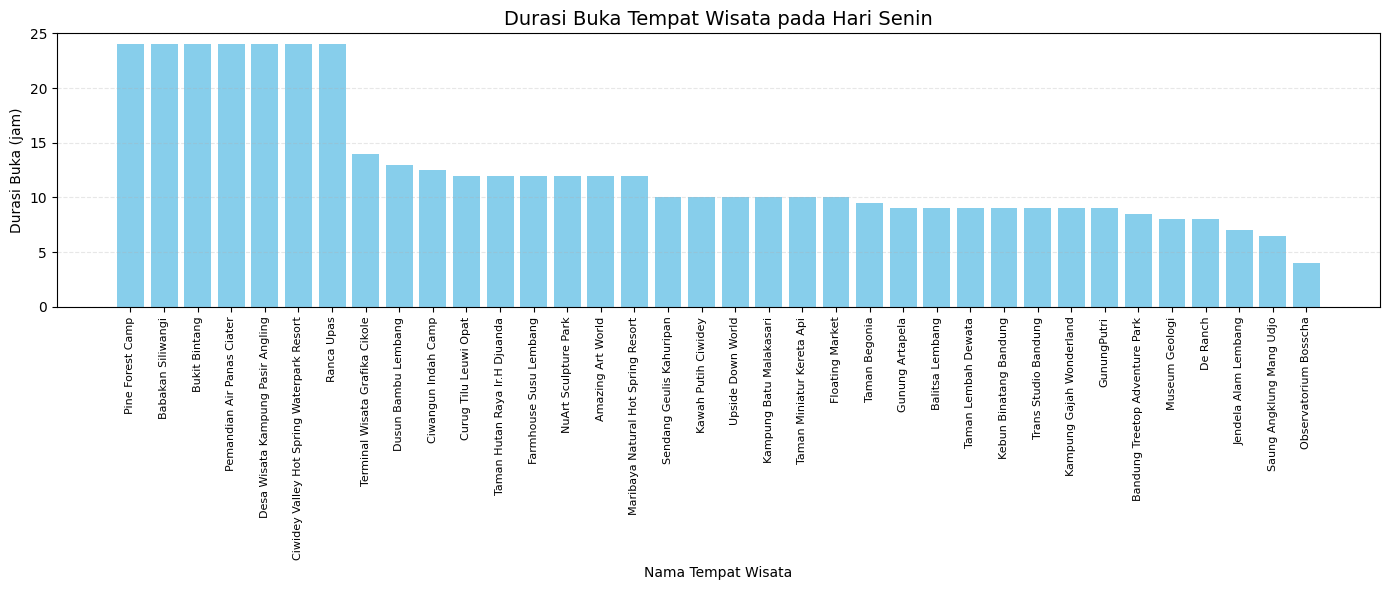

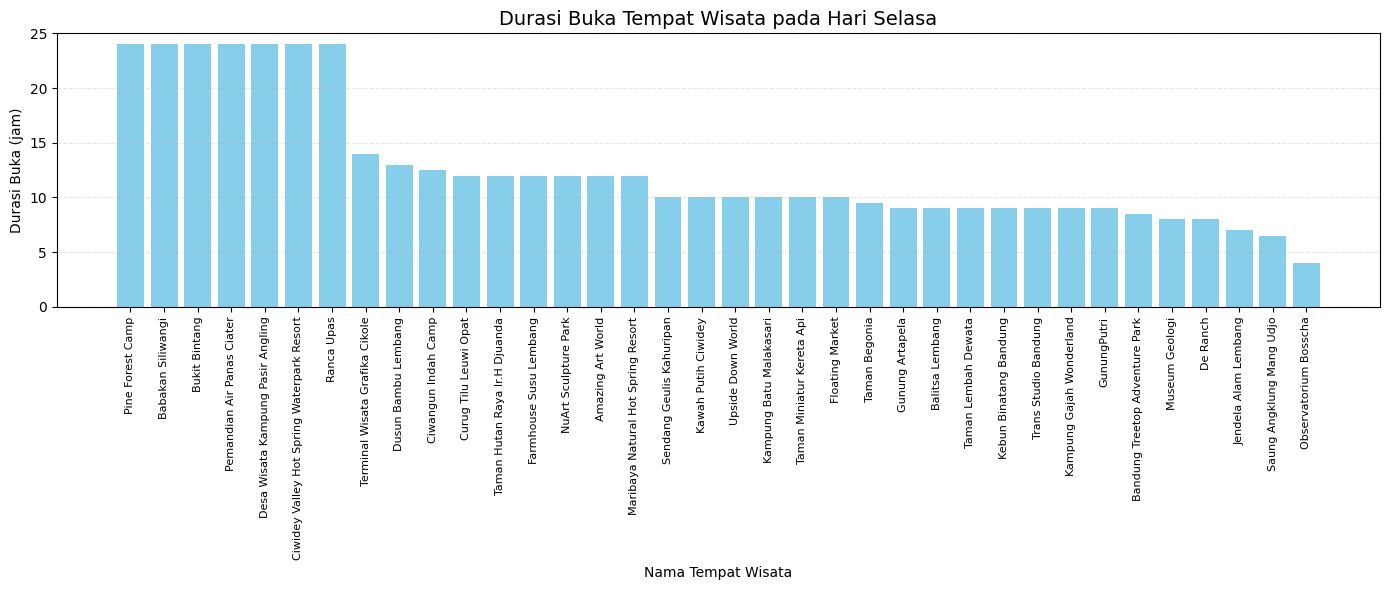

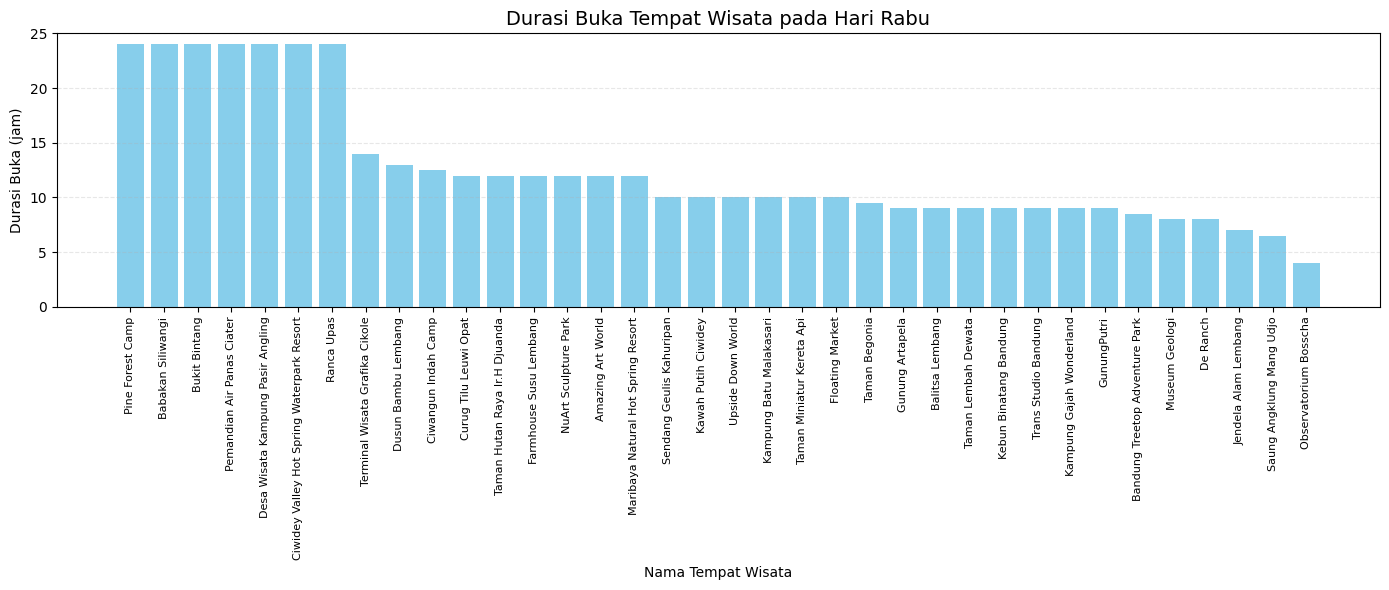

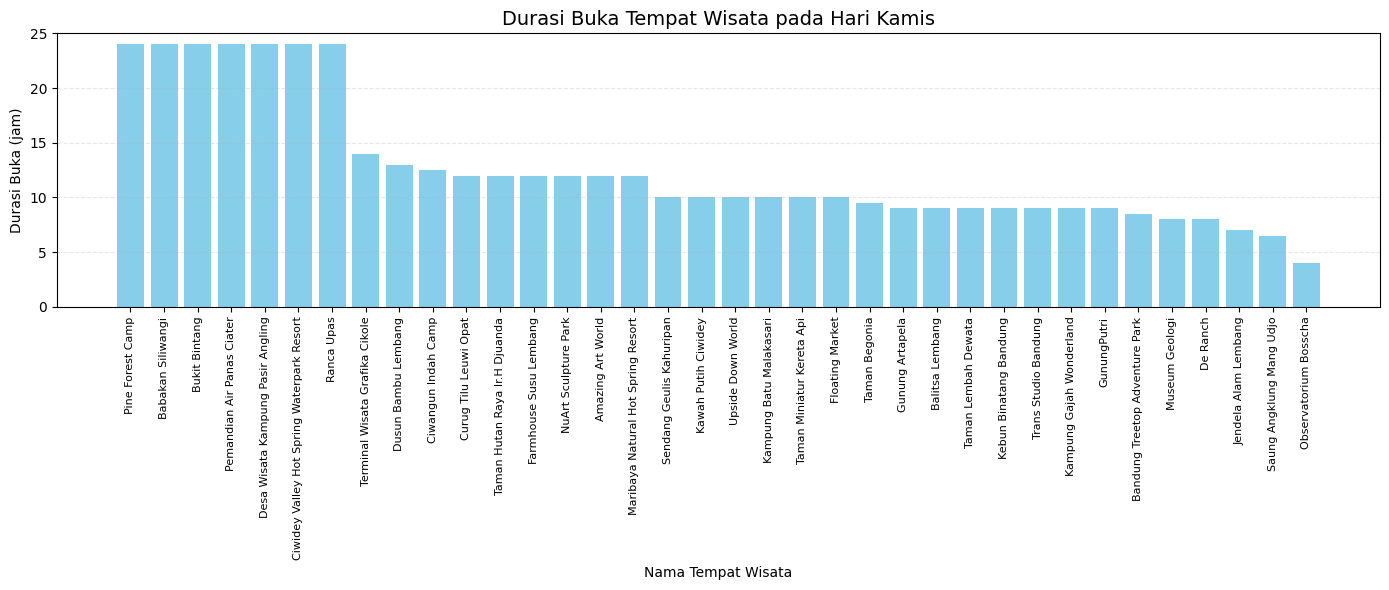

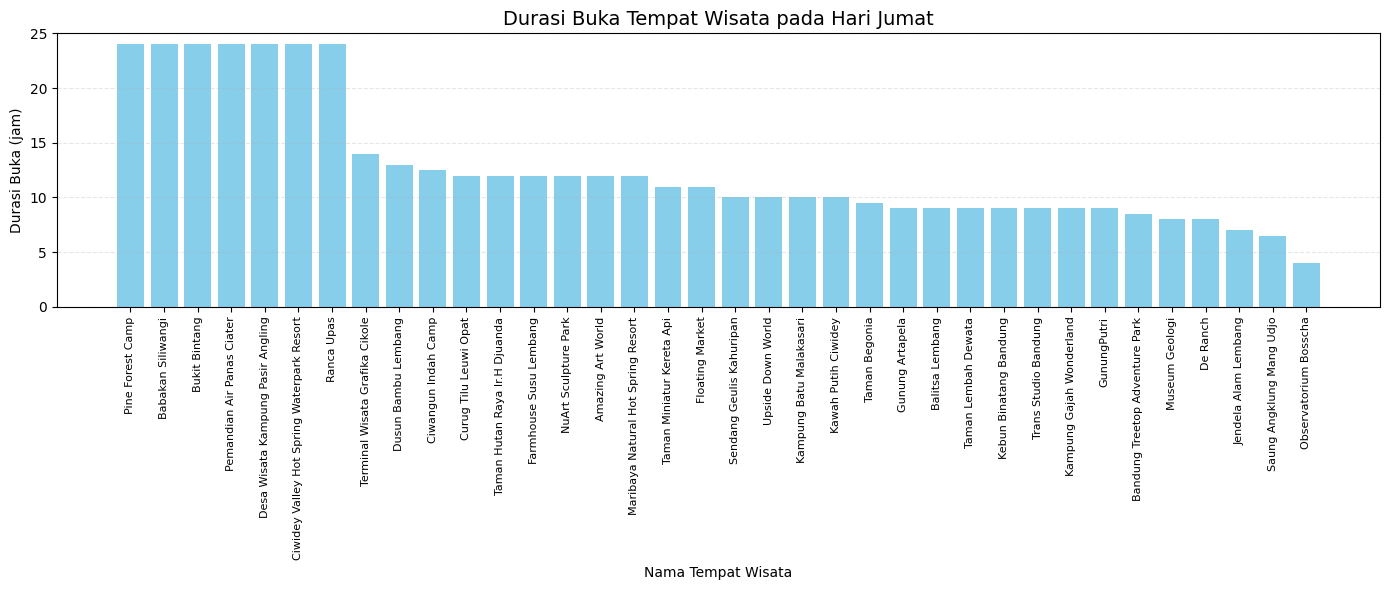

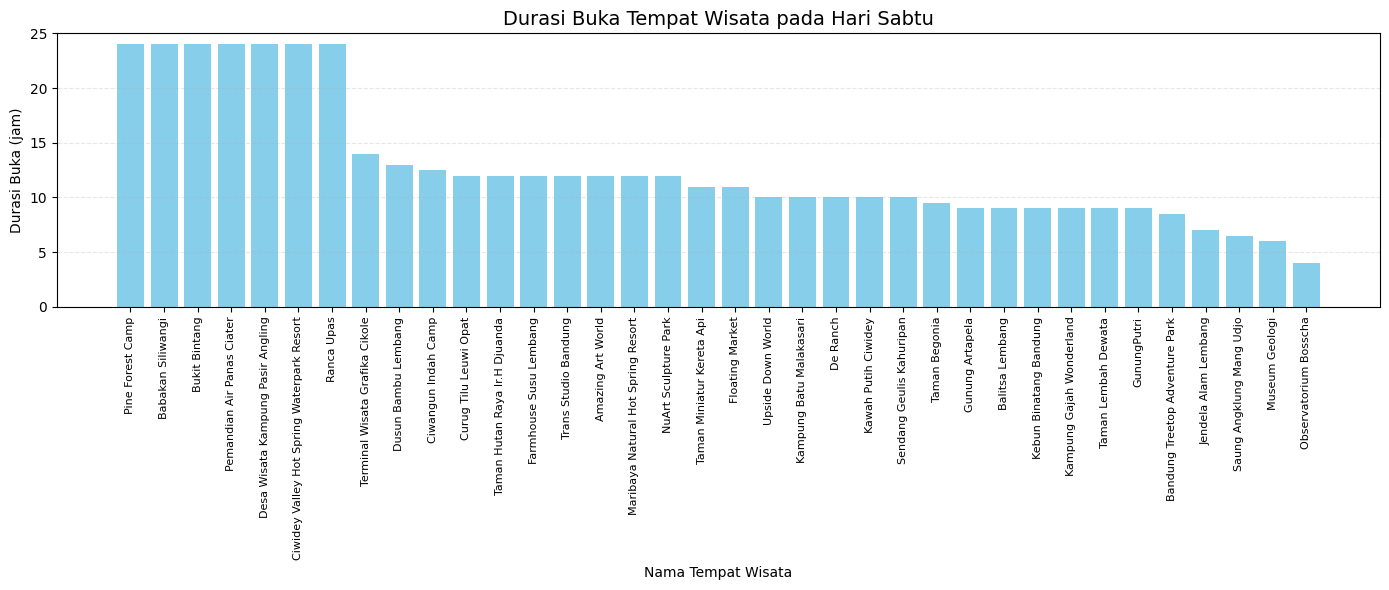

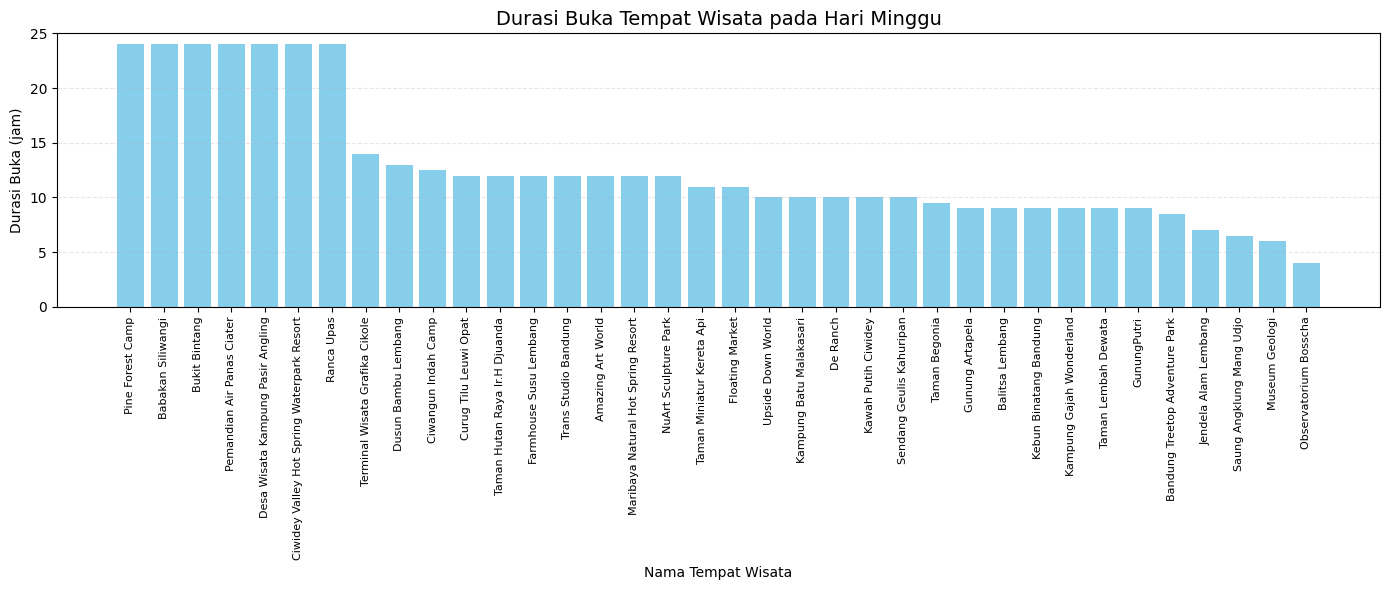

In [46]:
# Langkah 1: Salin DataFrame df_final untuk pengolahan durasi, guna menjaga data asli tetap aman
# Fungsi konversi jam buka-tutup ke durasi (jam)
from datetime import datetime
import matplotlib.pyplot as plt
def hitung_durasi(jam_str):
    if pd.isna(jam_str) or not isinstance(jam_str, str):
        return 0

    jam_str = jam_str.lower().replace("wib", "").replace("–", "-").strip()

    if "24 jam" in jam_str:
        return 24

    try:
        match = re.match(r"(\d{1,2}\.\d{2})\s*-\s*(\d{1,2}\.\d{2})", jam_str)
        if not match:
            return 0
        awal_str, akhir_str = match.groups()
        awal = datetime.strptime(awal_str, "%H.%M")
        akhir = datetime.strptime(akhir_str, "%H.%M")

        durasi = (akhir - awal).seconds / 3600
        return durasi
    except:
        return 0

# Asumsikan df_bersih sudah ada dan kolom "Jam Operasional" sudah bersih
df_jadwal = df_bersih["Jam Operasional"].apply(parse_operasional_campuran).apply(pd.Series)

# Gabungkan kembali dengan nama tempat
df_final = pd.concat([df_bersih[["Nama Tempat"]], df_jadwal], axis=1)

# Salin untuk hitung durasi
df_durasi = df_final.copy()

# Hitung durasi per hari
for hari in hari_list:
    df_durasi[hari] = df_durasi[hari].apply(hitung_durasi)

# Tampilkan bar chart durasi per hari
for hari in hari_list:
    plt.figure(figsize=(14, 6))
    data = df_durasi.sort_values(by=hari, ascending=False)

    plt.bar(data["Nama Tempat"], data[hari], color='skyblue')
    plt.title(f"Durasi Buka Tempat Wisata pada Hari {hari}", fontsize=14)
    plt.xlabel("Nama Tempat Wisata")
    plt.ylabel("Durasi Buka (jam)")
    plt.xticks(rotation=90, fontsize=8)
    plt.ylim(0, 25)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


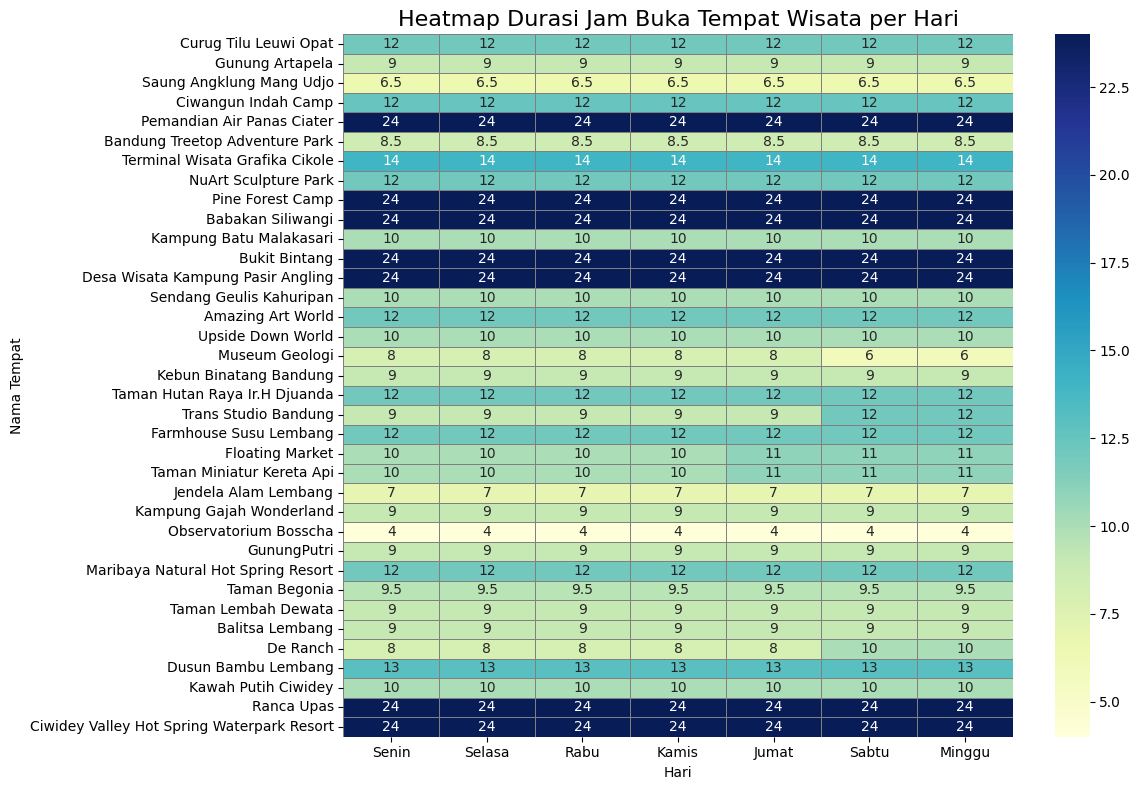

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Asumsikan df_heat sudah kamu buat, misalnya:
# df_heat = DataFrame pivot dari jam operasional tempat wisata

plt.figure(figsize=(12, 8))
df_heat = df_durasi.set_index("Nama Tempat")[hari_list]
sns.heatmap(df_heat, annot=True, cmap="YlGnBu", linewidths=0.5, linecolor="gray")
plt.title("Heatmap Durasi Jam Buka Tempat Wisata per Hari", fontsize=16)
plt.xlabel("Hari")
plt.ylabel("Nama Tempat")
plt.tight_layout()
plt.show()



#Deskripsi
## Jenis Wisata

In [48]:
# Fungsi untuk mengambil nama tempat dan deskripsi dari sebuah URL
def ambil_nama_dan_deskripsi(url):
    res = requests.get(url)
    soup = BeautifulSoup(res.text, "html.parser")

    # Ambil konten utama dari halaman
    konten = soup.find("div", class_="entry-content")
    data = []

    if konten:
        # Cari semua tag <h3> di dalam konten (biasanya berisi judul tempat)
        h3_tags = konten.find_all("h3")
        for tag in h3_tags:
            title = tag.get_text(strip=True)

            # Filter judul yang dimulai dengan angka (misal: "1. Tempat A")
            if any(char.isdigit() for char in title[:4]):
                # Bersihkan nama tempat dari angka dan simbol
                nama = re.sub(r"^\d+\.\s*", "", title).replace("❤️", "").strip()

                # Ambil deskripsi dari tag-tag berikutnya sampai ketemu <h3> baru
                deskripsi = ""
                next_tag = tag.next_sibling
                while next_tag:
                    if isinstance(next_tag, str):
                        next_tag = next_tag.next_sibling
                        continue
                    if next_tag.name == "h3":
                        break
                    if next_tag.name == "p":
                        teks = next_tag.get_text(strip=True)
                        # Hapus paragraf yang mengandung info teknis seperti alamat, tarif, dll
                        if not any(k in teks.lower() for k in ["alamat", "klik disini", "koordinat", "tarif", "htm", "jam"]):
                            deskripsi += teks + " "
                    next_tag = next_tag.next_sibling

                # Simpan jika deskripsi tidak kosong
                if deskripsi.strip():
                    data.append((nama, deskripsi.strip()))
                else:
                    print(f"[SKIPPED] {nama}")

    return data

# Proses scraping dari semua URL
semua_data = []
for url in urls:
    hasil = ambil_nama_dan_deskripsi(url)
    semua_data.extend(hasil)

# Buat DataFrame dari hasil scraping
df_deskripsi = pd.DataFrame(semua_data, columns=["Nama Tempat", "Deskripsi"])
df_deskripsi.index += 1  # Mulai index dari 1 agar lebih rapi

# Tampilkan hasil akhir
print(df_deskripsi.to_string(index=True))


                                   Nama Tempat                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [49]:
# Fungsi untuk mengklasifikasikan jenis wisata berdasarkan deskripsi
def jenis_wisata_fix(desc):
    desc = desc.lower()  # Ubah deskripsi jadi huruf kecil untuk mempermudah pencarian kata kunci

    # Kategori: Wisata Alam
    if any(k in desc for k in ["air terjun", "curug", "gunung", "bukit", "lembah", "perbukitan",
                               "danau", "situ", "kawah", "hutan", "goa", "tebing", "taman",
                               "pohon", "pegunungan", "sawah", "rusa", "cemara", "kuda", "kebun"]):
        return "Alam"

    # Kategori: Wisata Seni dan Budaya
    elif any(k in desc for k in ["angklung", "budaya", "wayang", "seni", "instalasi", "lukisan", "patung", "mural"]):
        return "Seni"

    # Kategori: Wisata Hiburan dan Rekreasi
    elif any(k in desc for k in ["taman bermain", "permainan", "wahana", "outbound", "petualangan", "adrenalin"]):
        return "Hiburan"

    # Kategori: Wisata Edukasi dan Ilmiah
    elif any(k in desc for k in ["museum", "perabotan", "galeri", "edukasi", "belajar", "ilmu", "workshop", "observatorium"]):
        return "Edukasi"

    # Kategori lainnya jika tidak sesuai semua
    else:
        return "Lainnya"

# Terapkan fungsi klasifikasi ke setiap deskripsi di dataframe
df_deskripsi["Jenis Wisata"] = df_deskripsi["Deskripsi"].apply(jenis_wisata_fix)

# Tampilkan nama tempat dan jenis wisata yang sudah diklasifikasi
print(df_deskripsi[["Nama Tempat", "Jenis Wisata"]].to_string(index=True))

                                   Nama Tempat Jenis Wisata
1                        Curug Tilu Leuwi Opat         Alam
2                                 Curug Malela         Alam
3                              Gunung Artapela         Alam
4                                  Gunung Nini         Alam
5                     Saung Angklung Mang Udjo         Seni
6                                 Situ Cisanti         Alam
7                        Bukit Gantole Cililin         Alam
8                                 Curug Cimahi         Alam
9                                Situ Cileunca         Alam
10                         Ciwangun Indah Camp         Alam
11                  Pemandian Air Panas Ciater         Alam
12                          Puncak Ciumbuleuit         Alam
13              Bandung Treetop Adventure Park      Hiburan
14              Terminal Wisata Grafika Cikole         Alam
15                                Situ Lembang         Alam
16                       Stone Garden Ge

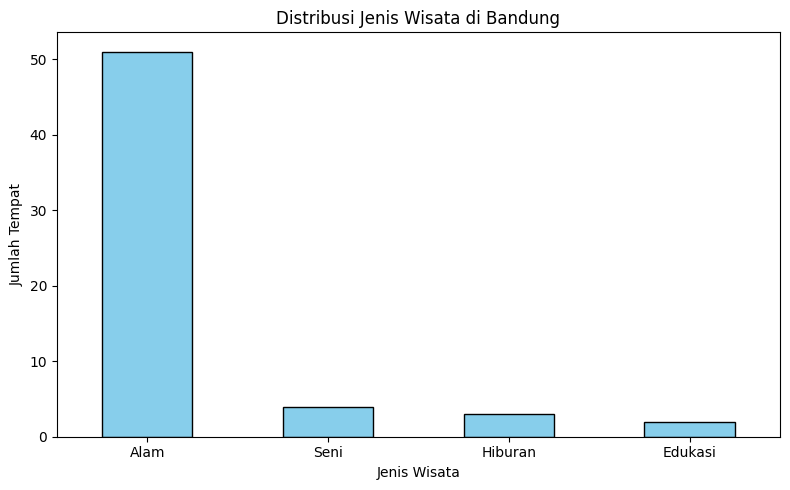

In [50]:
# Import library visualisasi
import matplotlib.pyplot as plt

# Hitung jumlah tempat untuk setiap jenis wisata
jenis_counts = df_deskripsi["Jenis Wisata"].value_counts()

# Buat figure untuk visualisasi bar chart
plt.figure(figsize=(8, 5))

# Plot bar chart distribusi jenis wisata
jenis_counts.plot(
    kind="bar",
    color="skyblue",      # Warna batang
    edgecolor="black"     # Garis tepi batang
)

# Tambahkan judul dan label sumbu
plt.title("Distribusi Jenis Wisata di Bandung")
plt.xlabel("Jenis Wisata")
plt.ylabel("Jumlah Tempat")

# Atur tampilan label sumbu x agar tidak miring
plt.xticks(rotation=0)

# Atur layout agar tidak terpotong
plt.tight_layout()

# Tampilkan plot
plt.show()


# Deskripsi
## Aktivitas

In [51]:
pip install scikit-learn


In [52]:
pip install nltk scikit-learn


In [53]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [54]:
from nltk.corpus import stopwords

stopwords_indonesia = stopwords.words('indonesian')


In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words=stopwords_indonesia, max_features=100)
X = vectorizer.fit_transform(df_deskripsi["Deskripsi"])


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


In [56]:
# Import modul regex
import re

# Fungsi untuk membersihkan teks deskripsi
def clean_text(text):
    text = text.lower()  # Ubah ke huruf kecil semua
    text = re.sub(r'[^a-z\s]', ' ', text)  # Hapus simbol, angka, dan tanda baca
    tokens = text.split()  # Pisahkan kata-kata
    tokens = [t for t in tokens if t not in stopwords_indonesia]  # Hapus stopwords
    return ' '.join(tokens)  # Gabungkan kembali jadi string

# Bersihkan kolom deskripsi dan simpan ke kolom baru
df_deskripsi["Deskripsi Bersih"] = df_deskripsi["Deskripsi"].apply(clean_text)

# Inisialisasi TF-IDF Vectorizer tanpa stop_words (karena sudah dibersihkan manual)
vectorizer = TfidfVectorizer(max_features=100)

# Transformasikan deskripsi bersih menjadi matriks TF-IDF
X = vectorizer.fit_transform(df_deskripsi["Deskripsi Bersih"])

# Cetak hasil vektorisasi (sparse matrix)
print(X)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 973 stored elements and shape (60, 100)>
  Coords	Values
  (0, 22)	0.20061410523924667
  (0, 15)	0.7305334585093012
  (0, 0)	0.2720224581802783
  (0, 91)	0.4358358205234326
  (0, 56)	0.06654043151763278
  (0, 45)	0.07458299768235696
  (0, 61)	0.1390718756184438
  (0, 85)	0.1043619226441859
  (0, 97)	0.048104356813776734
  (0, 14)	0.090403135593814
  (0, 31)	0.09667984778207998
  (0, 36)	0.08509625105467693
  (0, 95)	0.2179179102617163
  (0, 57)	0.0784121186695858
  (0, 46)	0.1043619226441859
  (0, 1)	0.09667984778207998
  (0, 21)	0.10030705261962333
  (0, 62)	0.1043619226441859
  (1, 15)	0.38452835079687236
  (1, 0)	0.6264278709941975
  (1, 91)	0.6021996278834386
  (1, 56)	0.12258629270382179
  (1, 61)	0.2562097248635119
  (1, 42)	0.12810486243175595
  (2, 56)	0.1340823361714886
  :	:
  (59, 56)	0.16840184076469558
  (59, 97)	0.12174345809727809
  (59, 14)	0.45758808885585217
  (59, 31)	0.4893585436709548
  (59, 95)	0.137877

In [57]:
# Import library untuk clustering
from sklearn.cluster import KMeans

# Inisialisasi dan jalankan algoritma KMeans dengan jumlah cluster tertentu (misal: 6)
kmeans = KMeans(n_clusters=6, random_state=42)

# Lakukan prediksi cluster berdasarkan data TF-IDF
clusters = kmeans.fit_predict(X)

# Tambahkan hasil cluster sebagai kolom baru di dataframe
df_deskripsi["Aktivitas Cluster"] = clusters

# Tampilkan hasil cluster untuk setiap tempat wisata
print(df_deskripsi["Aktivitas Cluster"])


1     4
2     4
3     5
4     0
5     3
6     5
7     0
8     4
9     2
10    2
11    2
12    5
13    3
14    2
15    5
16    5
17    0
18    1
19    2
20    0
21    2
22    2
23    0
24    3
25    5
26    3
27    5
28    0
29    3
30    4
31    5
32    5
33    3
34    4
35    2
36    2
37    2
38    4
39    3
40    3
41    5
42    3
43    3
44    1
45    3
46    1
47    2
48    5
49    4
50    2
51    5
52    2
53    0
54    3
55    1
56    5
57    0
58    5
59    2
60    2
Name: Aktivitas Cluster, dtype: int32


In [58]:
# Import numpy untuk manipulasi array
import numpy as np

# Ambil daftar istilah (fitur kata) dari TF-IDF vectorizer
terms = vectorizer.get_feature_names_out()

# Urutkan indeks kata di setiap centroid cluster berdasarkan bobot terbesar ke terkecil
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

# Tampilkan 10 kata teratas dari setiap cluster
for i in range(6):
    print(f"\nCluster {i}:")

    # Ambil 10 kata paling representatif untuk cluster ke-i
    top_kata = [terms[ind] for ind in order_centroids[i, :10]]

    # Cetak kata-kata tersebut
    print(", ".join(top_kata))


Cluster 0:
bukit, lokasi, bandung, ketinggian, meter, kawasan, alami, anak, hamparan, puncak

Cluster 1:
menu, seni, wisata, makan, wahana, suguhan, orang, kawasan, permainan, ruang

Cluster 2:
wisata, kebun, alam, bunga, camping, fasilitas, pengunjung, area, taman, ground

Cluster 3:
anak, wahana, rumah, permainan, wisata, kereta, sunda, api, batu, bandung

Cluster 4:
terjun, air, curug, meter, kolam, ketinggian, wisata, pohon, panas, batu

Cluster 5:
gunung, danau, kawah, alam, bandung, air, wisata, pemandangan, mata, puncak


In [59]:
# Pemetaan cluster numerik ke label aktivitas
cluster_to_label = {
    0: "Hiking / Trekking",
    1: "Hiburan / Kuliner",
    2: "Camping / Alam",
    3: "Hiburan Anak",
    4: "Aktivitas Air",
    5: "Alam Pegunungan"
}

# Tambahkan kolom baru "Aktivitas" berdasarkan hasil mapping dari cluster
df_deskripsi["Aktivitas"] = df_deskripsi["Aktivitas Cluster"].map(cluster_to_label)

# Tampilkan nama tempat beserta label aktivitasnya
print(df_deskripsi[["Nama Tempat", "Aktivitas"]].to_string(index=True))


                                   Nama Tempat          Aktivitas
1                        Curug Tilu Leuwi Opat      Aktivitas Air
2                                 Curug Malela      Aktivitas Air
3                              Gunung Artapela    Alam Pegunungan
4                                  Gunung Nini  Hiking / Trekking
5                     Saung Angklung Mang Udjo       Hiburan Anak
6                                 Situ Cisanti    Alam Pegunungan
7                        Bukit Gantole Cililin  Hiking / Trekking
8                                 Curug Cimahi      Aktivitas Air
9                                Situ Cileunca     Camping / Alam
10                         Ciwangun Indah Camp     Camping / Alam
11                  Pemandian Air Panas Ciater     Camping / Alam
12                          Puncak Ciumbuleuit    Alam Pegunungan
13              Bandung Treetop Adventure Park       Hiburan Anak
14              Terminal Wisata Grafika Cikole     Camping / Alam
15        

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd

# TF-IDF Vector dari deskripsi
vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(df_deskripsi['Deskripsi'])

# Clustering jadi 3 kelompok
kmeans = KMeans(n_clusters=3, random_state=42)
df_deskripsi['Keramaian Cluster'] = kmeans.fit_predict(X)

# Lihat hasil awal tiap cluster
for i in range(3):
    print(f"\nCluster {i}")
    print(df_deskripsi[df_deskripsi['Keramaian Cluster'] == i][['Nama Tempat', 'Deskripsi']].head(3))



Cluster 0
              Nama Tempat                                          Deskripsi
4             Gunung Nini  Keindahan sunrise dan sunset hanya salah satu ...
7   Bukit Gantole Cililin  Dinamakan Bukit Gantole karena di bukit yang m...
20              Gua Pawon  Gua Pawon cukup menarik sebagai objek wisata s...

Cluster 1
                       Nama Tempat  \
5         Saung Angklung Mang Udjo   
11      Pemandian Air Panas Ciater   
13  Bandung Treetop Adventure Park   

                                            Deskripsi  
5   Saung Angklung Mang Udjo selain menjadi destin...  
11  Sumber air panas yang mulai dikembangkan oleh ...  
13  “Fun, Adventure and Adrenalin” tema itulah yan...  

Cluster 2
             Nama Tempat                                          Deskripsi
1  Curug Tilu Leuwi Opat  Dinamakan Curug Tilu (Tiga), karena air terjun...
2           Curug Malela  Besar dan mempesona, gambaran itulah yang pant...
3        Gunung Artapela  Eksotisme pemandangan alam d

In [61]:
mapping = {
    0: "Tinggi",
    1: "Sedang",
    2: "Rendah"
}
df_deskripsi["Tingkat Keramaian"] = df_deskripsi["Keramaian Cluster"].map(mapping)
print(df_deskripsi[["Nama Tempat", "Tingkat Keramaian"]].to_string(index=True))

                                   Nama Tempat Tingkat Keramaian
1                        Curug Tilu Leuwi Opat            Rendah
2                                 Curug Malela            Rendah
3                              Gunung Artapela            Rendah
4                                  Gunung Nini            Tinggi
5                     Saung Angklung Mang Udjo            Sedang
6                                 Situ Cisanti            Rendah
7                        Bukit Gantole Cililin            Tinggi
8                                 Curug Cimahi            Rendah
9                                Situ Cileunca            Rendah
10                         Ciwangun Indah Camp            Rendah
11                  Pemandian Air Panas Ciater            Sedang
12                          Puncak Ciumbuleuit            Rendah
13              Bandung Treetop Adventure Park            Sedang
14              Terminal Wisata Grafika Cikole            Rendah
15                       

# Deskripsi
## Sentimen

In [62]:
def deteksi_sentimen(desc):
    desc = desc.lower()

    positif = [
        "indah", "menawan", "memesona", "bagus", "seru", "asyik",
        "menarik", "keren", "luar biasa", "cantik", "terbaik",
        "nyaman", "unik", "suka", "memuaskan", "tenang", "rekomendasi"
    ]
    negatif = [
        "bahaya", "berbahaya", "sulit", "jauh", "macet", "ramai sekali",
        "tidak nyaman", "kotor", "mahal", "sepi", "biasa saja",
        "kurang menarik", "ribet", "jelek", "membosankan", "mengecewakan"
    ]

    skor = 0
    for kata in positif:
        if kata in desc:
            skor += 1
    for kata in negatif:
        if kata in desc:
            skor -= 1

    if skor > 0:
        return "Positif"
    elif skor < 0:
        return "Negatif"
    else:
        return "Netral"


In [63]:
df_deskripsi["Sentimen"] = df_deskripsi["Deskripsi"].apply(deteksi_sentimen)
print(df_deskripsi[["Nama Tempat", "Sentimen"]].to_string(index=True))


                                   Nama Tempat Sentimen
1                        Curug Tilu Leuwi Opat  Positif
2                                 Curug Malela   Netral
3                              Gunung Artapela  Positif
4                                  Gunung Nini  Positif
5                     Saung Angklung Mang Udjo   Netral
6                                 Situ Cisanti  Positif
7                        Bukit Gantole Cililin   Netral
8                                 Curug Cimahi  Positif
9                                Situ Cileunca  Positif
10                         Ciwangun Indah Camp  Positif
11                  Pemandian Air Panas Ciater   Netral
12                          Puncak Ciumbuleuit   Netral
13              Bandung Treetop Adventure Park   Netral
14              Terminal Wisata Grafika Cikole  Positif
15                                Situ Lembang  Positif
16                       Stone Garden Geo Park  Positif
17                                  Bukit Moko  

In [64]:
# Fungsi rating berdasarkan sentimen
def rating(row):
    if row["Sentimen"] == "Positif":
        return 4
    elif row["Sentimen"] == "Netral":
        return 3
    else:
        return 0

# Hitung skor dan buat tabel akhir
df_deskripsi["Rating"] = df_deskripsi.apply(rating, axis=1)

tabel_final = df_deskripsi[["Nama Tempat", "Jenis Wisata", "Aktivitas", "Sentimen", "Rating"]]
print(tabel_final.to_string(index=True))


                                   Nama Tempat Jenis Wisata          Aktivitas Sentimen  Rating
1                        Curug Tilu Leuwi Opat         Alam      Aktivitas Air  Positif       4
2                                 Curug Malela         Alam      Aktivitas Air   Netral       3
3                              Gunung Artapela         Alam    Alam Pegunungan  Positif       4
4                                  Gunung Nini         Alam  Hiking / Trekking  Positif       4
5                     Saung Angklung Mang Udjo         Seni       Hiburan Anak   Netral       3
6                                 Situ Cisanti         Alam    Alam Pegunungan  Positif       4
7                        Bukit Gantole Cililin         Alam  Hiking / Trekking   Netral       3
8                                 Curug Cimahi         Alam      Aktivitas Air  Positif       4
9                                Situ Cileunca         Alam     Camping / Alam  Positif       4
10                         Ciwangun Inda

# Deskripsi
## Pengelompokkan dengan penambahan kolom tarif

In [65]:
# Definisikan fungsi untuk mengategorikan tarif berdasarkan isi kolom Harga/Tiket
def kategorikan_tarif(harga):
    # Cek jika datanya kosong atau NaN
    if pd.isna(harga):
        return "Tidak diketahui"

    # Ubah ke huruf kecil untuk memudahkan pencarian kata "gratis"
    harga = str(harga).lower()
    if "gratis" in harga:
        return "Gratis"

    # Ambil semua angka dari string (mengabaikan titik pemisah ribuan)
    angka_list = re.findall(r"\d+", harga.replace(".", ""))
    angka_list = [int(a) for a in angka_list if a.isdigit()]

    # Jika ditemukan angka, ambil harga minimum dan kategorikan
    if angka_list:
        min_harga = min(angka_list)
        if min_harga <= 15000:
            return "Murah"
        elif min_harga <= 30000:
            return "Menengah"
        else:
            return "Mahal"
    else:
        return "Tidak diketahui"

# Terapkan fungsi ke setiap baris kolom Harga/Tiket
df["Kategori Tarif"] = df["Harga/Tiket"].apply(kategorikan_tarif)

# Tampilkan jumlah tempat wisata per kategori tarif
print("Jumlah Wisata per Kategori Tarif:")
print(df["Kategori Tarif"].value_counts())


Jumlah Wisata per Kategori Tarif:
Kategori Tarif
Murah              38
Mahal               8
Gratis              8
Tidak diketahui     4
Menengah            2
Name: count, dtype: int64


In [66]:
def kategorikan_tarif(harga):
    if pd.isna(harga):
        return "Tidak diketahui"

    harga = str(harga).lower()
    if "gratis" in harga:
        return "Gratis"

    angka_list = re.findall(r"\d+", harga.replace(".", ""))
    angka_list = [int(a) for a in angka_list if a.isdigit()]

    if angka_list:
        min_harga = min(angka_list)
        if min_harga <= 15000:
            return "Murah"
        elif min_harga <= 30000:
            return "Menengah"
        else:
            return "Mahal"
    else:
        return "Tidak diketahui"

df["Kategori Tarif"] = df["Harga/Tiket"].apply(kategorikan_tarif)

df["Nama Tempat"] = df["Nama Tempat"].str.strip()
df_deskripsi["Nama Tempat"] = df_deskripsi["Nama Tempat"].str.strip()

df_final = df.merge(df_deskripsi[["Nama Tempat", "Sentimen"]], on="Nama Tempat", how="left")

def rating_sentimen(row):
    if row["Sentimen"] == "Positif":
        return 2
    elif row["Sentimen"] == "Netral":
        return 1
    else:
        return 0

def rating_tarif(row):
    kategori = row["Kategori Tarif"]
    if kategori == "Gratis":
        return 2
    elif kategori == "Murah":
        return 1
    elif kategori == "Menengah":
        return 1.5
    elif kategori == "Mahal":
        return 0
    else:
        return 0

df_final["Rating Sentimen"] = df_final.apply(rating_sentimen, axis=1)
df_final["Rating Tarif"] = df_final.apply(rating_tarif, axis=1)
df_final["Rating Total"] = df_final["Rating Sentimen"] + df_final["Rating Tarif"]

tabel_akhir = df_final[[
    "Nama Tempat", "Kategori Tarif", "Sentimen",
    "Rating Tarif", "Rating Sentimen", "Rating Total"
]]
print(tabel_akhir.to_string(index=True))

                                   Nama Tempat   Kategori Tarif Sentimen  Rating Tarif  Rating Sentimen  Rating Total
0                        Curug Tilu Leuwi Opat            Murah  Positif           1.0                2           3.0
1                                 Curug Malela            Murah   Netral           1.0                1           2.0
2                              Gunung Artapela            Murah  Positif           1.0                2           3.0
3                                  Gunung Nini            Murah  Positif           1.0                2           3.0
4                     Saung Angklung Mang Udjo            Mahal   Netral           0.0                1           1.0
5                                 Situ Cisanti            Murah  Positif           1.0                2           3.0
6                        Bukit Gantole Cililin           Gratis   Netral           2.0                1           3.0
7                                 Curug Cimahi          